In [1]:
# Path setup
import sys
import os

sys.path.append("/home/dchen/Random_Forest_Weights/")

# Basics:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Helpful:
from sklearn.model_selection import train_test_split

# Pipeline and ColumnsTransformer:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# models:
import statsmodels.api as sm

# my functions:
from src_rf.methods.calc_mean import *
from src_rf.methods.calc_weights import *
from src_rf.methods.calc_dist import *

### 1. Load Data

In [2]:
df = pd.read_csv("/home/dchen/Random_Forest_Weights/src_rf/data/energy_data_hourly.csv"
                 , index_col = 'datetime', parse_dates=True)

### 2. Explorative Data Analysis

In [3]:
df.head()

,total_energy_usage,residual_energy_usage,pump_storage,hour,month,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
datetime,,,,,,,,,,,,
2015-01-01 00:00:00,44.601,35.957,602.0,0,1,0,0,0,0,1,0,0
2015-01-01 01:00:00,43.455,34.642,347.0,1,1,0,0,0,0,1,0,0
2015-01-01 02:00:00,41.964,32.910,522.0,2,1,0,0,0,0,1,0,0
2015-01-01 03:00:00,40.618,31.548,1229.0,3,1,0,0,0,0,1,0,0
2015-01-01 04:00:00,39.936,30.775,1821.0,4,1,0,0,0,0,1,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68184 entries, 2015-01-01 00:00:00 to 2022-10-11 23:00:00
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_energy_usage     68184 non-null  float64
 1   residual_energy_usage  68184 non-null  float64
 2   pump_storage           68184 non-null  float64
 3   hour                   68184 non-null  int64  
 4   month                  68184 non-null  int64  
 5   Friday                 68184 non-null  int64  
 6   Monday                 68184 non-null  int64  
 7   Saturday               68184 non-null  int64  
 8   Sunday                 68184 non-null  int64  
 9   Thursday               68184 non-null  int64  
 10  Tuesday                68184 non-null  int64  
 11  Wednesday              68184 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 6.8 MB


In [5]:
df.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2022-10-11 14:00:00', '2022-10-11 15:00:00',
               '2022-10-11 16:00:00', '2022-10-11 17:00:00',
               '2022-10-11 18:00:00', '2022-10-11 19:00:00',
               '2022-10-11 20:00:00', '2022-10-11 21:00:00',
               '2022-10-11 22:00:00', '2022-10-11 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=68184, freq=None)

#### 2.1 Data Visualization

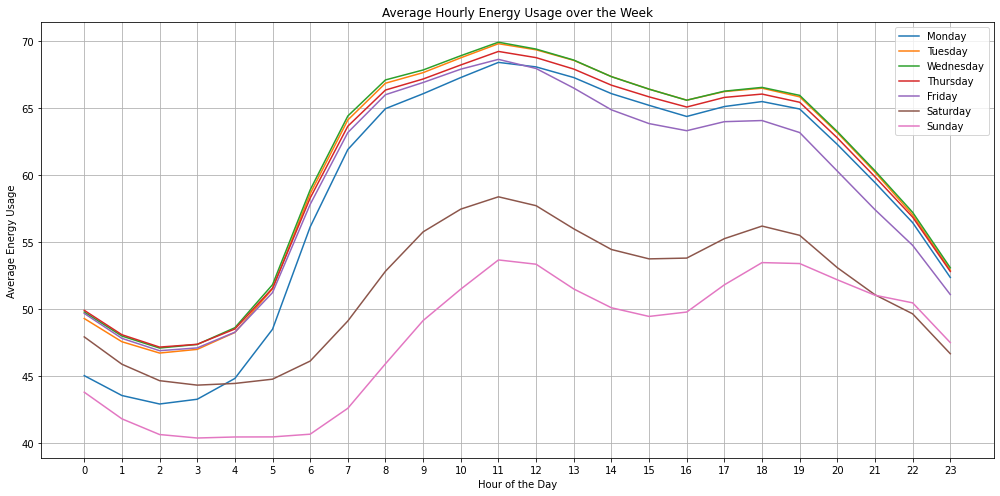

In [6]:
# Extract the day of the week and hour, then compute the average for each combination
hourly_avg = df.groupby([df.index.dayofweek, df.index.hour])['total_energy_usage'].mean()

# Mapping day of the week for better readability
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plotting
plt.figure(figsize=(14, 7))

for i, day in enumerate(days):
    plt.plot(hourly_avg[i], label=day)

plt.title('Average Hourly Energy Usage over the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Usage')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

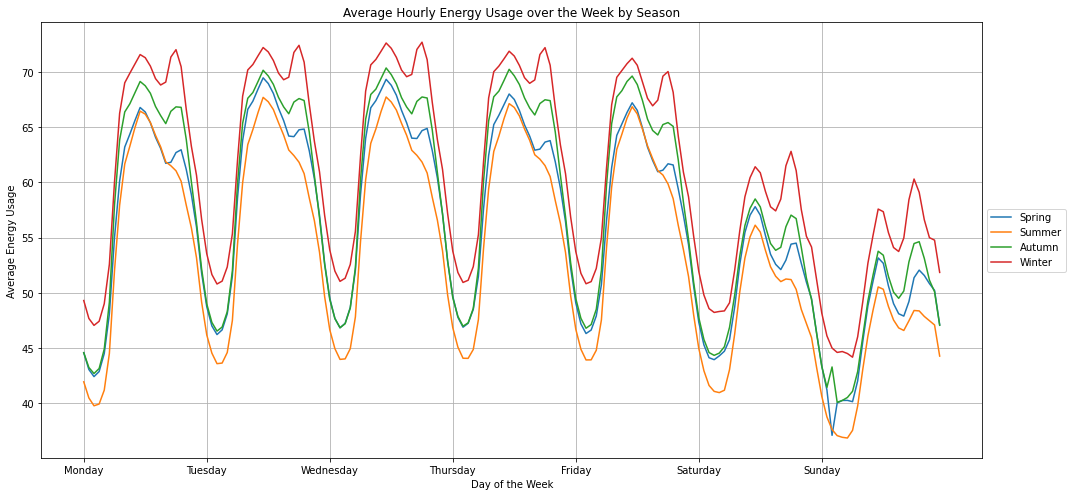

In [7]:
# Define seasons based on months
seasons = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

# Extract month, day of the week, and hour, then compute the average for each combination
hourly_avg = df.groupby([df.index.month, df.index.dayofweek, df.index.hour])['total_energy_usage'].mean()

# Prepare ticks and labels for the x-axis
x_ticks = list(range(0, 168, 24))
x_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plotting
plt.figure(figsize=(15, 7))

# Loop through each season and plot the average hourly consumption for the entire week
for season, months in seasons.items():
    seasonal_data = np.mean([np.array([hourly_avg[month][i].values for i in range(7)]).flatten() for month in months], axis=0)
    plt.plot(seasonal_data, label=season)

plt.title('Average Hourly Energy Usage over the Week by Season')
plt.xlabel('Day of the Week')
plt.ylabel('Average Energy Usage')
plt.xticks(x_ticks, x_labels)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Legend outside the plot for better clarity
plt.grid(True)
plt.tight_layout()
plt.show()

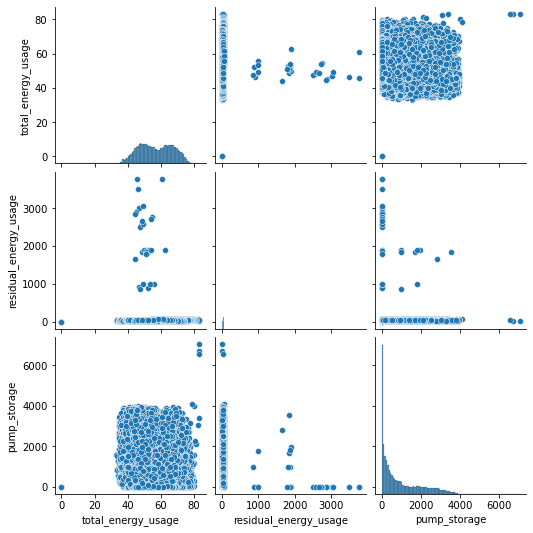

In [8]:
sns.pairplot(df.iloc[:,0:3])
plt.show()

### 3. Data Cleaning

### 4. Train Test Split

In [15]:
X = df.drop('total_energy_usage', axis = 1)
y = df['total_energy_usage']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3 ,shuffle=False, random_state=42)

In [17]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
X_train_const.drop('Monday', axis = 1, inplace = True)
X_test_const.drop('Monday', axis = 1, inplace = True)

### 5. Feature Engineering

### 6. Benchmark Models

In [18]:
def quantile_loss(y_true, y_pred, tau):
    return max(tau * (y_true - y_pred), (1 - tau) * (y_pred - y_true))

In [19]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

#### 6.1 Last 100 Benchmark

In [20]:
def baseline_last_100(timestamp, y):
    same_weekday_hour = y[y.index.weekday == timestamp.weekday()]
    same_weekday_hour = same_weekday_hour[same_weekday_hour.index.hour == timestamp.hour]
    latest_100 = same_weekday_hour.iloc[-100:]
    quantiles = latest_100.quantile([0.025, 0.25, 0.5, 0.75, 0.975])
    return quantiles.values

# Making predictions
predictions = [baseline_last_100(timestamp, y_train) for timestamp in y_test.index]

# Store predictions
pred_array = np.array(predictions)

# Compute quantile loss
quantile_levels = [0.025, 0.25, 0.5, 0.75, 0.975]
loss_array = np.zeros((len(y_test), 5))

for idx, (true_val, pred_vals) in enumerate(zip(y_test.values, predictions)):
    for j, (tau, q_val) in enumerate(zip(quantile_levels, pred_vals)):
        loss = quantile_loss(true_val, q_val, tau)
        loss_array[idx, j] = loss

average_loss = loss_array.mean()
print(average_loss)

1.1035525468505574


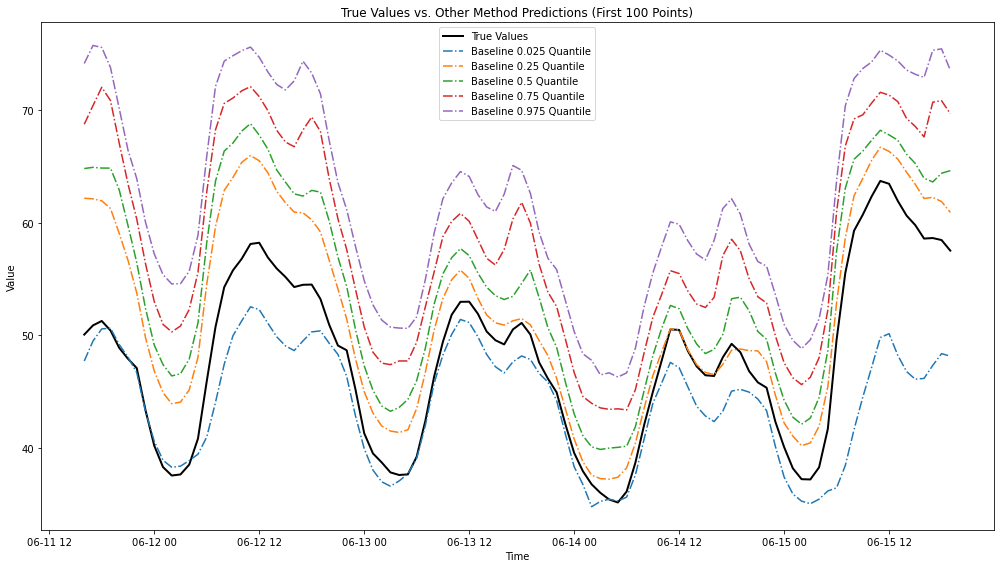

In [28]:
# Selecting first 100 data points
time_index_subset = y_test.index[:100]
y_test_subset = y_test[:100]
pred_subset = pred_array[:100]

# Plot for Other Method Predictions:
plt.figure(figsize=(14, 8))
plt.plot(time_index_subset, y_test_subset, label='True Values', color='black', linewidth=2)

for i, q in enumerate([0.025, 0.25, 0.5, 0.75, 0.975]):
    plt.plot(time_index_subset, pred_subset[:, i], label=f'Baseline {q} Quantile', linestyle='-.')

plt.title('True Values vs. Other Method Predictions (First 100 Points)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

#### 6.2 Quantile Regression

In [26]:
# Fit models for each quantile using training data with constant term added
qr_models = {}
for q in quantiles:
    qr_model = sm.QuantReg(y_train, X_train_const).fit(q=q)
    qr_models[q] = qr_model

# Predict using each QR model for all test samples with constant term added
qr_predictions = []
for xi in X_test_const.values:
    qr_pred_i = []
    for q in quantiles:
        qr_pred = qr_models[q].predict([xi])
        qr_pred_i.append(qr_pred[0])
    qr_predictions.append(qr_pred_i)

# Convert QR predictions to a numpy array
qr_pred_array = np.array(qr_predictions)

# Compute quantile loss for QR predictions
qr_loss_array = np.zeros((len(y_test), 5))
for idx, (true_val, qr_pred_vals) in enumerate(zip(y_test.values, qr_predictions)):
    for j, (tau, qr_q_val) in enumerate(zip(quantiles, qr_pred_vals)):
        qr_loss = quantile_loss(true_val, qr_q_val, tau)
        qr_loss_array[idx, j] = qr_loss

qr_average_loss = qr_loss_array.mean()
print(qr_average_loss)

1.7924929111488659


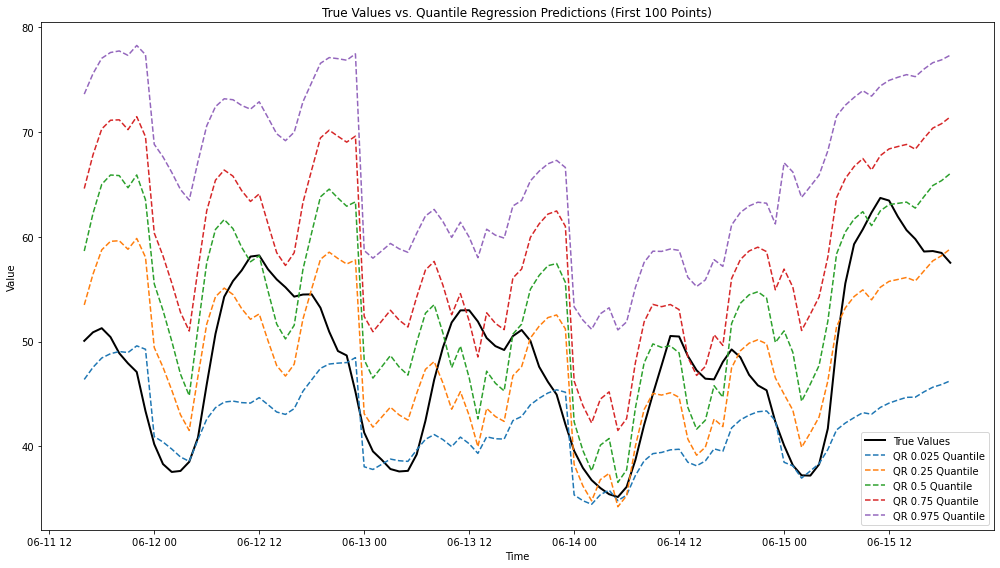

In [29]:
# Plot for Quantile Regression Predictions:
qr_pred_subset = qr_pred_array[:100]
plt.figure(figsize=(14, 8))
plt.plot(time_index_subset, y_test_subset, label='True Values', color='black', linewidth=2)

for i, q in enumerate([0.025, 0.25, 0.5, 0.75, 0.975]):
    plt.plot(time_index_subset, qr_pred_subset[:, i], label=f'QR {q} Quantile', linestyle='--')

plt.title('True Values vs. Quantile Regression Predictions (First 100 Points)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

#### 6.3 Quantile Random Forest

In [48]:
rf_pred_array = np.load('/Data/Delong_BA_Data/rf_weights/energy_quantile_preds.npy')
rf_loss_array = np.zeros((len(y_test), 5))
for count, q in enumerate(quantiles):
    for i in range(y_test.shape[0]):
        rf_loss_array[i,count] = quantile_loss(y_test.values[i], rf_pred_array[i,count], q)
        
rf_average_loss = rf_loss_array.mean()
print(rf_average_loss)

0.7302881297661254


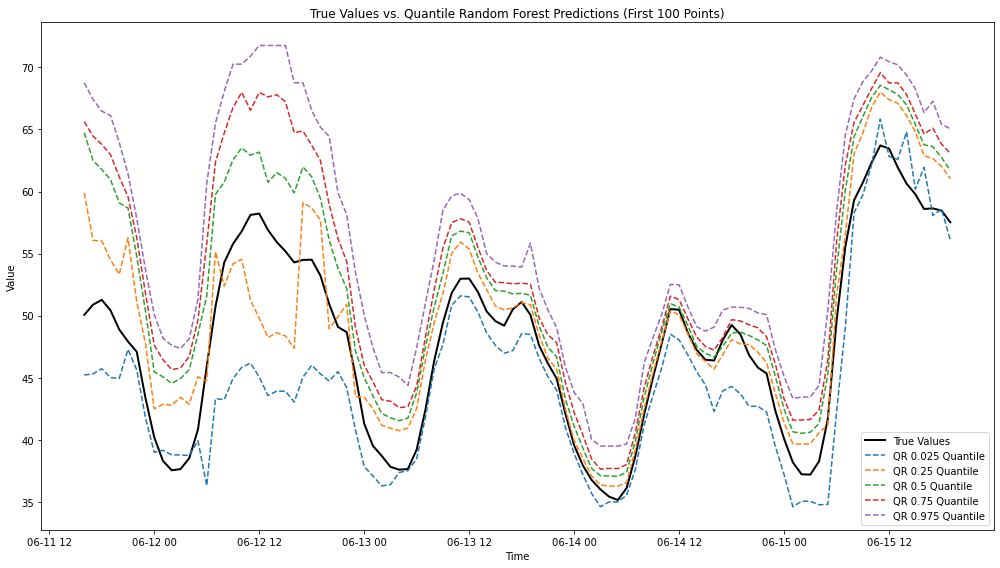

In [51]:
# Plot for Quantile Random Forest Predictions:
rf_pred_subset = rf_pred_array[:100]
plt.figure(figsize=(14, 8))
plt.plot(time_index_subset, y_test_subset, label='True Values', color='black', linewidth=2)

for i, q in enumerate([0.025, 0.25, 0.5, 0.75, 0.975]):
    plt.plot(time_index_subset, rf_pred_subset[:, i], label=f'QR {q} Quantile', linestyle='--')

plt.title('True Values vs. Quantile Random Forest Predictions (First 100 Points)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()